In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Radial basis function interpolation

- you are given scattered points {x_i,f_i}
- you want to find a function s(x_i) = f_i that interpolates these x_i,f_i 
- this function shuld be smooth inbetween the {x_i,f_i}'s

we approximate s(x) as a weighted sum of radially symmetric kernels centered at each x_i
$$
s(x) = \Sigma_{i=1}^N \omega_i \phi(\Vert x - x_i \Vert)
$$

where $\omega_i$ are unknown weights and $\phi(r)$ is a __radial__ basis function.

To find the $\{ \omega_i\}$'s we ENFORCE 
$$ 
s(x_j) = \Sigma_{i=1}^N \omega_i \phi(\vert x_j - x_i\vert) = f_j
$$ 

This  gives a linear system $\mathbf{\Phi} \vec{\omega} = \vec{f}$ where $\Phi_{ij} = \phi(\vert x_i - x_j \vert)$. 

Then $\vec{\omega} = \mathbf{\Phi}^{-1} \vec{f}$

Once we have the _optimized_ $\vec{\omega}$ we can use that for evaluating the the values in-between the $\{x_i,f_i\}$s

questions:
- how do you cap the $N$?
- does s(x_j) have to be exactly equal to f_j or are we just happy with a minimization like we did with linear interpolation?


### Common RBF choices
- Gaussian: $\exp[-\epsilon r^2]$
- Multi-Quadratic: $\sqrt{1 + (\epsilon r)^2}$
- Inverse MQ: $1/\sqrt{1 + (\epsilon r)^2}$
- Thin Plate Spline : $r^2 \log(r)$

In [ ]:
np.random.randn(10)/100

In [ ]:
# 1D example
# we'll sample from f(x) = sin(x) 
# and then reconstruct the s(x)
# we'll use gaussian RBF

np.random.seed(0)
nSamples = 30
x = np.linspace(0, 2*np.pi, nSamples)
f = np.sin(x) + np.random.randn(nSamples)/1000

# Define RBF
def gaussian_rbf(r, epsilon=1.0):
    return np.exp(-(epsilon*r)**2)

# build the Phi Matrix
def rbf_interpolation_matrix(x,rbf,epsilon):
    N = len(x)
    Phi = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            r = abs(x[i] - x[j])
            Phi[i,j] = rbf(r,epsilon)
    return Phi

# compute weights
epsilon = 1.0
Phi = rbf_interpolation_matrix(x, gaussian_rbf, epsilon)
w = np.linalg.solve(Phi,f)

# we now haev the optimized weights
# so lets use that to plot the function eveywhere

nEvals = 200
x_eval = np.linspace(0,2*np.pi,nEvals)
Phi_eval = np.zeros((len(x_eval), len(x)))
for i,xe in enumerate(x_eval):
    r = abs(xe - x)
    Phi_eval[i,:] = gaussian_rbf(r,epsilon)

f_interp = Phi_eval @ w

plt.figure(figsize=(8,5))
plt.scatter(x, f, color='r', label='Samples')
plt.plot(x_eval, np.sin(x_eval), 'g--', label='True function')
plt.plot(x_eval, f_interp, 'b', label='RBF interpolation')
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("RBF Interpolation using Gaussian kernel")
plt.show()


Question - will imposing boundary conditions make it more accurate at the edges? 

In [ ]:
# 2D version 
# f(x,y) = sin(x)*cos(y)

np.random.seed(0)
nSamples = 200
x = np.random.uniform(-2*np.pi, 2*np.pi, nSamples)
y = np.random.uniform(-2*np.pi, 2*np.pi, nSamples)
f = np.sin(x)*np.cos(y) #+ np.random.randn(nSamples,nSamples)/100

points = np.vstack([x,y]).T

# def pairwise_dist(A,B):
#     aElts,aDim = A.shape # number of elements, number of dimensions for each element
#     bElts,bDim = B.shape # number of elements, number of dimensions for each element
#     dist = np.zeros((aElts,bElts))
#     for i in range(aElts):
#         for j in range(bElts):
#             diff = A[i] - B[i]
#             dist[i,j] = np.sqrt(np.sum(diff**2)) # Euclidean norm
    
#     return dist

# A and B are matrices. Each row of the matrix is a point in N-dimension. in this example N = 2 just (x,y)
# efficient method for computing distances between all points in one go. numpy uses C code under the hood
def pairwise_dist(A, B):
    return np.linalg.norm(A[:,None,:] - B[None,:,:], axis=-1)

epsilon = 1.0
Phi = gaussian_rbf(pairwise_dist(points,points),epsilon)
w = np.linalg.solve(Phi,f)


# # Evaluate on a grid
nEvals = 100
xg = np.linspace(-2*np.pi, 2*np.pi, nEvals)
yg = np.linspace(-2*np.pi, 2*np.pi, nEvals)
Xg,Yg = np.meshgrid(xg,yg)
grid = np.stack([Xg.ravel(), Yg.ravel()],axis=1)

Phi_eval = gaussian_rbf(pairwise_dist(grid,points),epsilon)
f_interp = Phi_eval @ w
f_interp = f_interp.reshape(Xg.shape)

plt.figure(figsize=(6,5))
plt.contourf(Xg, Yg, f_interp, levels=30, cmap='viridis')
plt.scatter(x, y, c='r', s=10)
plt.title("2D RBF Interpolation")
plt.colorbar(label='f(x,y)')
plt.show()

# Create a 3D surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the interpolated surface
surf = ax.plot_surface(Xg, Yg, f_interp, cmap='viridis', edgecolor='none')

# Optionally, overlay the original sample points
# ax.scatter(x, y, f_interp.flatten()[::len(f_interp)//len(x)], c='r', s=20, label='Sample Points')
ax.scatter(x, y, f, c='r', s=20, label='Sample Points')

# Labels and title
ax.set_title("3D RBF Interpolation Surface")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='f(x,y)')

plt.show()


## 3D point cloud interpolation

- you are given a point cloud $\{ p_i\} \in \mathbb{R}^3$ which were sampled from a surface
- find a smooth function $f(\vec{x}) : \mathbb{R}^3 \rightarrow \mathbb{R}$ such that
    - $f(\vec{p_i}) = 0$ and
    - $f(x) > 0$ outside the surface and
    - $f(x) < 0$ inside the surface
- This is called a __zero level set__ $\{ x | f(x) = 0\}$

We represent $f(\vec{r})$ as an RBF plus a polynomial. The polynomial is to help avoid trivial zero solutions or if the RBF matrix were singular
$$ f(\vec{r}) = \Sigma_{i=1}^{N} \omega_i \phi(\vert \vec{r} - \vec{p_i} \vert)  + a_0 + a_1.r_x + a_2.r_y + a_3.r_z$$ 
We need to evaluate $\vec{\omega}, a_0,a_1,a_2,a_3 $

### TRICK - Use offset points to generate more points. 
We have points on the surface $f(\vec{p_i}) = 0$. so to generate more points we can perturb them by a small $\delta$ along the normal to the surface to get more points:
- $\vec{p_i}^+ = \vec{p_i} + \delta.\hat{n}$ (outside the surfacE)
- $\vec{p_i}^- = \vec{p_i} - \delta.\hat{n}$ (inside the surfacE)
- $f(\vec{p_i}^+) = +\delta$
- $f(\vec{p_i}^-) = -\delta$
- $f(\vec{p_i}) = 0$
- $\vec{f} $ is a $3N \times 1$ vector
  
Now we've generated $2N$ points for each point. So we have $3N$ points. \
So now, for each point $\vec{q_j}$ (which includes originals and offsets), we get 
$$ \Sigma_{i=0}^{N} \omega_i \phi(\vert \vec{q}_j - \vec{p}_i\vert) + a_0 + a_1.q_{jx} + a_2.q_{jy} + a_3.q_{jz} = f_j$$ 


<!-- 
$$ 
\begin{bmatrix} 
\Phi & \mathbf{P} \\ \mathbf{P}^T & 0
\end{bmatrix} 
\begin{bmatrix} 
\vec{\omega} \\ \vec{a}
\end{bmatrix} = 
\begin{bmatrix} 
f \\ 0
\end{bmatrix} 
$$  -->

$$ \mathbf{\Phi}_{3N \times N} \vec{w}_{N \times 1} + \mathbf{P}_{3N \times 4} \vec{a}_{4 \times 1} = \vec{f}_{3N \times 1}$$ 

where 
- $ 0 \leq j \leq 3N$ where $N$ is the number of sample points. 
- $\Phi_{ji} = \phi(\vert \vec{q}_j - \vec{p}_i \vert )$
- $\Phi$ is a $3N \times N$ matrix for the distances between the $3N \vec{q}$ points and the $N \vec{p}$ points
- $\mathbf{P}$ is $3N \times 4$ matrix. Each row is = $[1, q_{ix}, q_{iy}, q_{iz} ]$
- $\vec{\omega}$ is a vector of length $N$. It has weights only for the original points.
- $\vec{f}$ is a vector of lenght $3N$. It is the value of the surface for all points (original + generated)
- $\vec{a} = [a_0, a_1, a_2, a_3]$

In [64]:
Phi.shape, P.shape, f.shape, w.shape, a.shape

((750, 250), (750, 4), (750,), (250,), (4,))

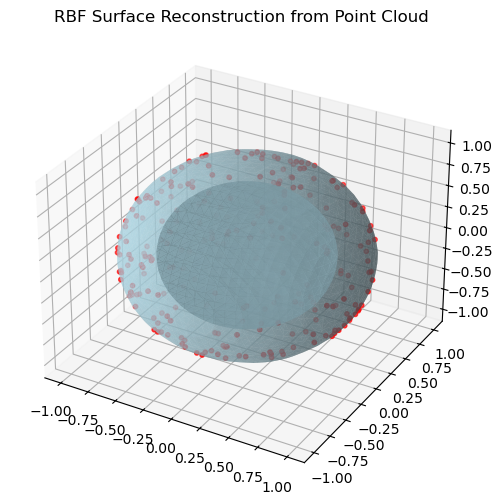

In [63]:
# 3D point cloud interpolation
# we'll sample points from a spehere 

np.random.seed(0)
N = 250
phi = 2 * np.pi * np.random.rand(N)
costheta = 2*np.random.rand(N) - 1
theta = np.arccos(costheta)
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)
points = np.vstack([x, y, z]).T # N rows, 3 cols

#Normals 
normals = points.copy()

delta = 0.05
points_in = points - delta * normals
points_out = points + delta * normals

# combine all poitns
Q = np.vstack([
    points,              # original surface points 
    points_in,           # generated inside-points
    points_out           # generated outside-points
])
# Q has 3N rows, 3 cols

f = np.concatenate([
    np.zeros(N),          # original surface points
    -delta*np.ones(N),    # generated inside points
    +delta*np.ones(N)     # generated outside points
])
# f has 3N rows, 1 col

# Gaussian RBF
def gaussian_rbf(r, epsilon=2.0):
    return np.exp(-(epsilon * r)**2)

# Pairwise distance
def pairwise_dist(A, B):
    return np.linalg.norm(A[:, None, :] - B[None, :, :], axis=-1)

# build block matrix equation
epsilon = 2.0
Phi = gaussian_rbf(pairwise_dist(Q, points), epsilon)
# Phi has 3N rows and N cols

# Polynomial terms
P = np.hstack([np.ones((len(Q),1)), Q])
# P has 3N rows and 4 cols

# A = np.block([
#     [Phi, P],
#     [P.T, np.zeros((4,4))]
# ])

A = np.block([
    [Phi, P]
])

# b = np.concatenate([f,np.zeros(4)])
b = f.copy()

# solve for \vec{omega} and \vec{a}
w_a = np.linalg.lstsq(A,b,rcond=None)[0]
w = w_a[:-4]
a = w_a[-4:]

# Evaluate on a grid
grid_x,grid_y,grid_z = [np.linspace(-1.5,1.5,40)]*3
X,Y,Z = np.meshgrid(grid_x,grid_y,grid_z)
grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

Phi_eval = gaussian_rbf(pairwise_dist(grid, points), epsilon)
P_eval = np.hstack([np.ones((len(grid),1)), grid])
f_eval = Phi_eval @ w + P_eval @ a
f_eval = f_eval.reshape(X.shape)

# Visualize implicit surface (f=0)
from skimage import measure
verts, faces, normals, values = measure.marching_cubes(f_eval, level=0, spacing=(grid_x[1]-grid_x[0],)*3)

# Plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:,0]-1.5, verts[:,1]-1.5, faces, verts[:,2]-1.5,
                color='lightblue', alpha=0.6, linewidth=0.1)
ax.scatter(points[:,0], points[:,1], points[:,2], color='r', s=10)
ax.set_title("RBF Surface Reconstruction from Point Cloud")
plt.show()


- Drawback - we assumed perfect sphere so we got normals analytically
- To estimate the normals we can use PCA to approximate the surface near a cluster of points. 
- This is much like the 2D MLS algorithm

The idea is
- for each point, find $k$ nearest neighbors
- fit a local plane using PCA
- the surface is spanned by the biggest two eigenvalue's eigenvectors 
- the normal vector is the smallest eigenvalue's eigenvector

Algorithmically
- Given $\{\vec{q_j}\}$ points around the point $\vec{p_i}$
- compute the covariance matrix $$ C = \frac{1}{k} \Sigma_{j} (\vec{q_j} - \vec{\langle q \rangle }) (\vec{q_j} - \vec{\langle q \rangle })^T $$ 

In [66]:
from sklearn.neighbors import NearestNeighbors

def estimate_normals(points, k=20):
    N = len(points)
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='kd_tree').fit(points)
    dists , idx = nbrs.kneighbors(points)

    normals = np.zeros((N,3))
    for i in range(N):
        neighbors = points[idx[i,1:]] # exclude itself
        centroid = neighbors.mean(axis=0)
        C = (neighbors - centroid).T @ (neighbors - centroid)
        eigvals,eigvecs = np.linalg.eigh(C)
        normal = eigvecs[:,0]
        normals[i] = normal

    return normals

# ensure that all normals are pointing "inward"
def orient_normals(points, normals, k = 10):
    N = len(points)
    nbrs = NearestNeighbors(n_neighbors = k+1, algorithm='kd_tree').fit(points)
    _, idx = nbrs.kneighbors(points)
    visited = np.zeros(N,dtype=bool)
    queue = [0]
    visited[0] = True

    while queue:
        i = queue.pop()
        for j in idx[i,1:]:
            if not visited[j]:
                # flip the normal if it's inconsistent
                dot_prod = np.dot(normals[i], normals[j])
                if dot_prod < 0:
                    normals[j] *= -1
                visited[j] = True
                queue.append(j)
    return normals


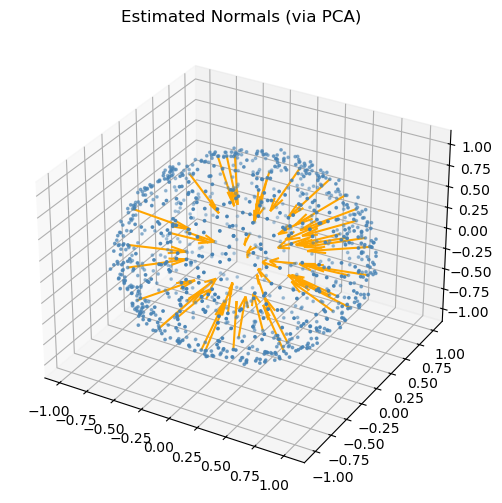

In [71]:
# try out the PCA normal evaluation algorithm on a noisy spehere

np.random.seed(1)
N = 1000
phi = 2 * np.pi * np.random.rand(N)
costheta = 2 * np.random.rand(N) - 1
theta = np.arccos(costheta)
r = 1 + 0.02 * np.random.randn(N)
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)
points = np.vstack([x,y,z]).T

normals = estimate_normals(points,k=30)
normals = orient_normals(points,normals)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(points[::20,0], points[::20,1], points[::20,2],
          normals[::20,0], normals[::20,1], normals[::20,2],
          length=0.5, color='orange')
ax.scatter(points[:,0], points[:,1], points[:,2], s=3, color='steelblue')
ax.set_title("Estimated Normals (via PCA)")
plt.show()



